In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy
import numpy as np
import glob
from scipy.stats import mannwhitneyu
from matplotlib.pyplot import subplot_mosaic as mosaic
import matplotlib.transforms as mtransforms
import math
import matplotlib
import warnings
from IPython.display import Image, display
warnings.filterwarnings("ignore")

### Quality control of sex annotations
TODO: add line to histograms, like in modmatcher paper

Output of QC with modmatcher from modmatcher_QC.R can be found in the subdirectory /modmatcher. Workflow taken from https://rpubs.com/seungyeul/471026

In [2]:
# list genes (ensembl ids) that were used as sex markers in MODMatcher paper (pmid 25122495)
genes = ['ENSG00000129824', 'ENSG00000067048']
ct_sels_init = ['BRCA', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LUSC', 'PCPG', 'READ', 'STAD']
num_buckets = 10

In [3]:
def align(pheno, expr):
    keep = pheno.index.isin(expr.index)
    pheno = pheno[keep]
    pheno = pheno[pheno.index.isin(expr.index)]
    samples = pheno.index            
    expr = expr.loc[samples]
    expr = expr.loc[:, (expr.std() != 0)]
    pheno = pheno[pheno.index.isin(expr.index)]
    return pheno, expr

def get_expression_data(cohort):
    try:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.htseq_fpkm.tsv'), sep='\t', header=0, index_col=0)
    except:
        expression_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'brca_metabric.tsv'), sep='\t', header=0, index_col=0)
    expression_data.columns = expression_data.columns.str.split('.').str[0].tolist()
    return expression_data

def get_pheno_data(cohort):
    try:
        tissue_type_field, tissue_type = 'sample_type.samples', 'Primary Tumor'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', f'TCGA-{cohort}.GDC_phenotype.tsv'), sep='\t', header=0, index_col='submitter_id.samples')
    except:
        tissue_type_field, tissue_type = 'Sample Type', 'Primary'
        pheno_data = pd.read_csv(os.path.join(os.getcwd(), 'datasets', 'metabric_brca_pheno.tsv'), sep='\t', header=0, index_col=0)
    assert len(pheno_data.iloc[0]) == len(pheno_data.iloc[0].values)
    pheno_data['cohort'] = str(cohort)
    pheno_data =  pheno_data[pheno_data[tissue_type_field] == tissue_type]
    return pheno_data

### Computation of possible mismatches based on euclidean distance of sample-specific values for ENSG00000129824 and ENSG00000067048 from cohort-specific means for ENSG00000129824 and ENSG00000067048, for male and female cohorts

BRCA
possible mismatches, females: 0
possible mismatches, men: 0

max female: ENSG00000129824    2.381077
ENSG00000067048    0.651030
dtype: float64
min male: ENSG00000129824    5.703854
ENSG00000067048    1.799206
dtype: float64


COAD
possible mismatches, females: 1
possible mismatches, men: 26

max female: ENSG00000129824    3.560558
ENSG00000067048    1.246688
dtype: float64
min male: ENSG00000129824    1.067355
ENSG00000067048    0.195087
dtype: float64


GBM
possible mismatches, females: 0
possible mismatches, men: 0

max female: ENSG00000129824    3.308717
ENSG00000067048    0.972826
dtype: float64
min male: ENSG00000129824    3.905362
ENSG00000067048    2.097339
dtype: float64


HNSC
possible mismatches, females: 0
possible mismatches, men: 32

max female: ENSG00000129824    1.359981
ENSG00000067048    0.384909
dtype: float64
min male: ENSG00000129824    0.010362
ENSG00000067048    0.004117
dtype: float64


KIRC
possible mismatches, females: 2
possible mismatches, men: 11

max 

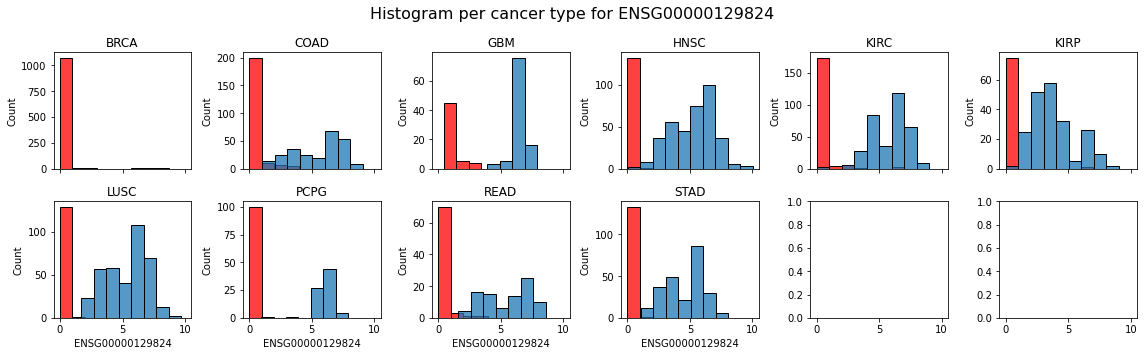

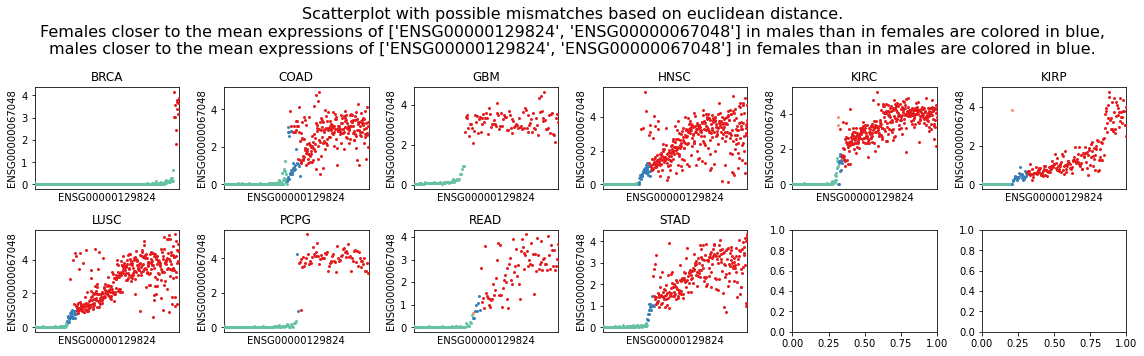

In [4]:
fig, axs = plt.subplots(2, 6, figsize=(16,5), sharex=True, sharey=False)
fig.suptitle(f'Histogram per cancer type for {genes[0]}', fontsize=16)

fig2, axs2 = plt.subplots(2, 6, figsize=(16,5), sharex=False, sharey=False)
fig2.suptitle(f'Scatterplot with possible mismatches based on euclidean distance.\nFemales closer to the mean expressions of {genes} in males than in females are colored in blue,\nmales closer to the mean expressions of {genes} in females than in males are colored in blue.', fontsize=16)

i = j = 0
for cohort in ct_sels_init:
    print(cohort)
    # read single data
    expr = get_expression_data(cohort)
    pheno = get_pheno_data(cohort)
    # align pheno and expr
    pheno, expr = align(pheno, expr)
    expr = expr[genes]
    try:
        pheno = pheno[pheno['gender.demographic'].notna()]
        pheno_data = pheno[pheno['gender.demographic'] != 'not reported']
        samples_f = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'female'].index.tolist()
        samples_m = pheno.loc[pheno['gender.demographic'].astype('string').str.strip() == 'male'].index.tolist()
    except:
        pheno = pheno[pheno['Sex'].notna()]
        samples_f = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Female'].index.tolist()
        samples_m = pheno.loc[pheno['Sex'].astype('string').str.strip() == 'Male'].index.tolist()
        
    expr_f = expr.loc[samples_f]
    expr_m = expr.loc[samples_m]

    expr_f['dist_f'] = expr_f.apply(lambda x: np.linalg.norm(np.array(x[genes]) - expr_f[genes].mean()), axis=1)
    expr_f['dist_m'] = expr_f.apply(lambda x: np.linalg.norm(np.array(x[genes]) - expr_m[genes].mean()), axis=1)
    expr_f['mismatch'] = expr_f['dist_m']<expr_f['dist_f']
    print('possible mismatches, females: ' + str(len(expr_f[expr_f['mismatch']])))

    expr_m['dist_m'] = expr_m.apply(lambda x: np.linalg.norm(np.array(x[genes]) - expr_m[genes].mean()), axis=1)
    expr_m['dist_f'] = expr_m.apply(lambda x: np.linalg.norm(np.array(x[genes]) - expr_f[genes].mean()), axis=1)
    expr_m['mismatch'] = expr_m['dist_f']<expr_m['dist_m']
    print('possible mismatches, men: ' + str(len(expr_m[expr_m['mismatch']])))
    
    print('\nmax female: ' + str(expr_f[genes].max()))
    print('min male: ' + str(expr_m[genes].min()))
    
    sns.histplot(expr.loc[samples_f][genes[0]], binwidth=1, kde=False, ax=axs[j,i], color='red')
    sns.histplot(expr.loc[samples_m][genes[0]], binwidth=1, kde=False, ax=axs[j,i])
    axs[j,i].title.set_text(cohort)

    sns.swarmplot(expr_f, x=genes[0], y=genes[1], ax=axs2[j,i], hue='mismatch', palette=sns.color_palette("Set2"), size=3, legend=False)
    sns.swarmplot(expr_m, x=genes[0], y=genes[1], ax=axs2[j,i], hue='mismatch', palette=sns.color_palette("Set1"), size=3, legend=False)
    axs2[j,i].title.set_text(cohort)
    axs2[j,i].set_xticks([])#[axs2[j,i].get_xticks()[0], axs2[j,i].get_xticks()[len(axs2[j,i].get_xticks())-1]])
    i += 1
    if i == 6:
        i = 0
        j += 1
    print('\n')
        
fig.tight_layout()
fig2.tight_layout()
